In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')

In [3]:
test_data = pd.read_csv("/kaggle/input/titanic/test.csv")

In this version I will model closely an example done by KG, particularly in his tutorial part 3 with feature engineering.

In [4]:
#Let's combine the training and testing datasets to perform feature engineering on
test_data['Survived'] = np.nan
full_data = pd.concat([train_data, test_data], sort = True)
full_data.head()

,Age,Cabin,Embarked,Fare,Name,Parch,PassengerId,Pclass,Sex,SibSp,Survived,Ticket
0,22.0,NaN,S,7.2500,"Braund, Mr. Owen Harris",0,1,3,male,1,0.0,A/5 21171
1,38.0,C85,C,71.2833,"Cumings, Mrs. John Bradley (Florence Briggs Th...",0,2,1,female,1,1.0,PC 17599
2,26.0,NaN,S,7.9250,"Heikkinen, Miss. Laina",0,3,3,female,0,1.0,STON/O2. 3101282
3,35.0,C123,S,53.1000,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",0,4,1,female,1,1.0,113803
4,35.0,NaN,S,8.0500,"Allen, Mr. William Henry",0,5,3,male,0,0.0,373450


In [5]:
# explore the nan's
full_data.isnull().sum().sort_values(ascending = False)

Cabin          1014
Survived        418
Age             263
Embarked          2
Fare              1
Ticket            0
SibSp             0
Sex               0
Pclass            0
PassengerId       0
Parch             0
Name              0
dtype: int64

In [6]:
#explore nans as a percentage
full_data.isnull().mean().sort_values(ascending = False)

Cabin          0.774637
Survived       0.319328
Age            0.200917
Embarked       0.001528
Fare           0.000764
Ticket         0.000000
SibSp          0.000000
Sex            0.000000
Pclass         0.000000
PassengerId    0.000000
Parch          0.000000
Name           0.000000
dtype: float64

In [7]:
#replace embarked nans with 'S', the most common value. aka 'the mode'
full_data.Embarked.fillna('S', inplace = True)

In [8]:
#make sex and embarked numerical variables
full_data["Sex"][full_data["Sex"] == "male"] = 0
full_data["Sex"][full_data["Sex"] == "female"] = 1

full_data["Embarked"][full_data["Embarked"] == "S"] = 0
full_data["Embarked"][full_data["Embarked"] == "C"] = 1
full_data["Embarked"][full_data["Embarked"] == "Q"] = 2

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/lib/python3.6/si

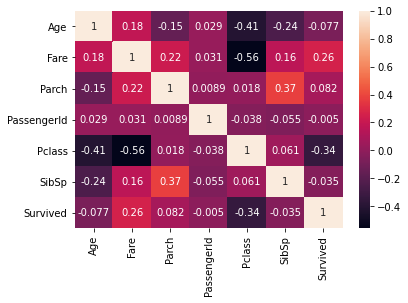

In [9]:
#correlation matrix to get ideas for the following impute steps
import matplotlib.pyplot as plt
import seaborn as sns

sns.heatmap(full_data.corr(), annot = True)

Still need to impute Age, Fare, and Cabin. Now we have the information to do it:
Age is correlated highest with Pclass,
Fare is also most correlated with Pclass

In [10]:
#Impute Age and Fare using its median value grouped by Pclass
full_data['Age'] = full_data.groupby("Pclass")['Age'].transform(lambda x: x.fillna(x.median()))
full_data['Fare'] = full_data.groupby("Pclass")['Fare'].transform(lambda x: x.fillna(x.median()))

In [11]:
#Cabin had a ton of missing values, but we don't want to lose the information there.
#We will give the nans a value of 'U' for undefined until further feature engineering
full_data.Cabin.fillna('U', inplace = True)

In [12]:
#all the nulls taken care of. Except Survived since we haven't predicted those yet.
full_data.isnull().mean().sort_values(ascending = False)

Survived       0.319328
Ticket         0.000000
SibSp          0.000000
Sex            0.000000
Pclass         0.000000
PassengerId    0.000000
Parch          0.000000
Name           0.000000
Fare           0.000000
Embarked       0.000000
Cabin          0.000000
Age            0.000000
dtype: float64

In [13]:
#Cabin had a lot of missing information, so let's make a new feature called 'floor' from its first letter.
full_data['Floor'] = full_data.Cabin.str[0]
full_data.Floor.unique().tolist()

['U', 'C', 'E', 'G', 'D', 'A', 'B', 'F', 'T']

In [14]:
#now that Floor is manageable let's recode it numerically
full_data["Floor"][full_data["Floor"] == "A"] = 0
full_data["Floor"][full_data["Floor"] == "B"] = 1
full_data["Floor"][full_data["Floor"] == "C"] = 2
full_data["Floor"][full_data["Floor"] == "D"] = 3
full_data["Floor"][full_data["Floor"] == "E"] = 4
full_data["Floor"][full_data["Floor"] == "F"] = 5
full_data["Floor"][full_data["Floor"] == "G"] = 6
full_data["Floor"][full_data["Floor"] == "T"] = 7
full_data["Floor"][full_data["Floor"] == "U"] = 8
full_data.Floor.head()

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys

0    8
1    2
2    8
3    2
4    8
Name: Floor, dtype: object

In [15]:
#Let's see if we can do something similar with 'Name' by extracting the title. (Like Mr. or Mrs.)
#This time we need regular expressions
#We will take all the letters before a '.' but after a space
import re
full_data['Title'] = full_data.Name.str.extract(' ([A-Za-z]+)\.', expand = False)
full_data.Title.unique().tolist()

['Mr',
 'Mrs',
 'Miss',
 'Master',
 'Don',
 'Rev',
 'Dr',
 'Mme',
 'Ms',
 'Major',
 'Lady',
 'Sir',
 'Mlle',
 'Col',
 'Capt',
 'Countess',
 'Jonkheer',
 'Dona']

In [16]:
#what's the distribution of each of these titles?
full_data.Title.value_counts(normalize = True)

Mr          0.578304
Miss        0.198625
Mrs         0.150497
Master      0.046600
Dr          0.006112
Rev         0.006112
Col         0.003056
Major       0.001528
Mlle        0.001528
Ms          0.001528
Mme         0.000764
Jonkheer    0.000764
Don         0.000764
Sir         0.000764
Lady        0.000764
Dona        0.000764
Capt        0.000764
Countess    0.000764
Name: Title, dtype: float64

In [17]:
#the top three contain most of the information, so we'll combine the others into... 'Other'
full_data['Title'] = full_data.Title.replace(['Master', 'Dr', 'Rev', 'Col', 
                                              'Major', 'Ms', 'Mlle', 'Countess', 
                                              'Lady', 'Dona', 'Sir', 'Jonkheer', 
                                              'Don', 'Capt', 'Mme'], 'Other')
full_data.Title.unique().tolist()

['Mr', 'Mrs', 'Miss', 'Other']

In [18]:
#excellent, now just like the others recode it numerically
title_category = {'Mr':1, 'Miss':2, 'Mrs':3, 'Master':4, 'Other':5}
full_data['Title'] = full_data['Title'].map(title_category)
full_data.Title.head().tolist()

[1, 3, 2, 3, 1]

In [19]:
#last feature to create here. Family size. This is the sum of Parch and Sibsp plus 1
full_data['Family_size'] = full_data['Parch'] + full_data['SibSp'] + 1
full_data.Family_size.head()

0    2
1    2
2    1
3    2
4    1
Name: Family_size, dtype: int64

In [20]:
#here we discard the columns that we have extracted the information from 
full_data = full_data.drop(['Parch', 'SibSp', 'Cabin', 'Name', 'Ticket'], axis = 1)
full_data.head()

,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,Floor,Title,Family_size
0,22.0,0,7.2500,1,3,0,0.0,8,1,2
1,38.0,1,71.2833,2,1,1,1.0,2,3,2
2,26.0,0,7.9250,3,3,1,1.0,8,2,1
3,35.0,0,53.1000,4,1,1,1.0,2,3,2
4,35.0,0,8.0500,5,3,0,0.0,8,1,1


In [21]:
print(full_data.shape)
print(full_data.isnull().mean().sort_values(ascending = False))
full_data.head()

(1309, 10)
Survived       0.319328
Family_size    0.000000
Title          0.000000
Floor          0.000000
Sex            0.000000
Pclass         0.000000
PassengerId    0.000000
Fare           0.000000
Embarked       0.000000
Age            0.000000
dtype: float64


,Age,Embarked,Fare,PassengerId,Pclass,Sex,Survived,Floor,Title,Family_size
0,22.0,0,7.2500,1,3,0,0.0,8,1,2
1,38.0,1,71.2833,2,1,1,1.0,2,3,2
2,26.0,0,7.9250,3,3,1,1.0,8,2,1
3,35.0,0,53.1000,4,1,1,1.0,2,3,2
4,35.0,0,8.0500,5,3,0,0.0,8,1,1


Excellent! Besides 'Survived' there are no null values, and all our data is numerical.

In [22]:
#Now we can separate into the train and test sets again
final = full_data[full_data['Survived'].isna()].drop('Survived', axis = 1)
train = full_data[full_data['Survived'].notna()]
#survived needs to be an integer for the competition output
train['Survived'] = train.Survived.astype('int8')
output_key = final['PassengerId']
final.shape

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


(418, 9)

In [23]:
#Separate the train data into predictor and target variables
X = train.drop('Survived', axis = 1)
y = train['Survived']

In [24]:
#make train/test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [25]:
#show correlations
import matplotlib.pyplot as plt
import seaborn as sns

train_corr = train_data.corr()
train_corr.style.background_gradient(cmap='coolwarm').set_precision(2)

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
PassengerId,1,-0.005,-0.035,0.037,-0.058,-0.0017,0.013
Survived,-0.005,1,-0.34,-0.077,-0.035,0.082,0.26
Pclass,-0.035,-0.34,1,-0.37,0.083,0.018,-0.55
Age,0.037,-0.077,-0.37,1,-0.31,-0.19,0.096
SibSp,-0.058,-0.035,0.083,-0.31,1,0.41,0.16
Parch,-0.0017,0.082,0.018,-0.19,0.41,1,0.22
Fare,0.013,0.26,-0.55,0.096,0.16,0.22,1


Sufficiently uncorrelated

In [26]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

Try a logistic regression instead

In [27]:
#let's try logistic regression here
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import cross_val_score

#instantiate and fit Logistic Regression model
logreg = LogisticRegression(C = 0.05179474679231213, max_iter = 50, penalty = 'l2', solver = 'newton-cg')
logreg.fit(X_train_scaled, y_train)
logreg_preds = logreg.predict(X_test_scaled)
print(logreg.score(X_test_scaled, y_test))
print(confusion_matrix(y_test, logreg_preds))
print(classification_report(y_test, logreg_preds))

logreg_auc = cross_val_score(logreg, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(logreg_auc)
print(np.mean(logreg_auc))

0.8044692737430168
[[94 16]
 [19 50]]
              precision    recall  f1-score   support

           0       0.83      0.85      0.84       110
           1       0.76      0.72      0.74        69

    accuracy                           0.80       179
   macro avg       0.79      0.79      0.79       179
weighted avg       0.80      0.80      0.80       179

[0.85103306 0.85702479 0.87983281 0.88678451 0.86447811]
0.8678306576739179


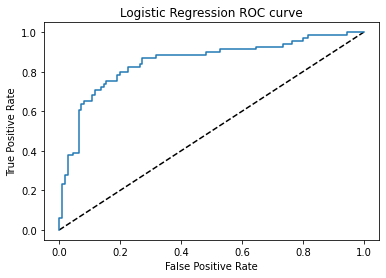

In [28]:
#we can also plot this on an ROC curve
from sklearn.metrics import roc_curve
logreg_preds_proba = logreg.predict_proba(X_test_scaled)[:,1]
fpr, tpr, thresholds = roc_curve(y_test, logreg_preds_proba)
plt.plot([0,1], [0,1], 'k--')
plt.plot(fpr, tpr, label = 'Logistic Regression')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Logistic Regression ROC curve')
plt.show()

In [29]:
#with the ROC curve we can quantify the overall performance with AUC
from sklearn.metrics import roc_auc_score
print(roc_auc_score(y_test, logreg_preds_proba))
#let's also cross validate this
from sklearn.model_selection import cross_val_score
cv_scores = cross_val_score(logreg, X_train_scaled, y_train, cv=5, scoring = 'roc_auc')
print(cv_scores)
print(np.mean(cv_scores))

0.8499341238471674
[0.85103306 0.85702479 0.87983281 0.88678451 0.86447811]
0.8678306576739179


In [30]:
#use grid search cv to test multiple values of random forest hyperparams
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.ensemble import RandomForestClassifier

estimator_space = np.arange(50, 500, 50)
depth_space = np.arange(10,110,10)
features_space = ['sqrt']

params = {'n_estimators' : estimator_space,
         'max_depth' : depth_space,
         'max_features' : features_space}
rfmodel = RandomForestClassifier()
rfmodel_cv = RandomizedSearchCV(rfmodel, params, cv = 5)
rfmodel_cv.fit(X_train_scaled, y_train)
print("Test score is {}".format(rfmodel_cv.score(X_test_scaled, y_test)))
print("Tuned Random Forest Parameters: {}".format(rfmodel_cv.best_params_))
print("Best score is {}".format(rfmodel_cv.best_score_))

Test score is 0.8212290502793296
Tuned Random Forest Parameters: {'n_estimators': 350, 'max_features': 'sqrt', 'max_depth': 10}
Best score is 0.824544469614892


In [31]:
#aaaand while they're both still running let's try a knn model for funzies
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier()
knn.fit(X_train_scaled, y_train)
knn_preds = knn.predict(X_test_scaled)
print(knn.score(X_test_scaled, y_test))
print(confusion_matrix(y_test, knn_preds))

knn_auc = cross_val_score(knn, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(knn_auc)
print(np.mean(knn_auc))

0.770949720670391
[[94 16]
 [25 44]]
[0.80764463 0.83367769 0.8862069  0.88552189 0.80671296]
0.8439528118172319


In [32]:
#let's also try a linear SVC
from sklearn.svm import LinearSVC
svm = LinearSVC()
svm.fit(X_train_scaled, y_train)
svm_preds = svm.predict(X_test_scaled)
print(svm.score(X_test_scaled, y_test))
print(confusion_matrix(y_test, svm_preds))

svm_auc = cross_val_score(svm, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(svm_auc)
print(np.mean(svm_auc))

0.8100558659217877
[[95 15]
 [19 50]]


/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarn

[0.85454545 0.85867769 0.87628004 0.87710438 0.86489899]
0.8663013098593035


/opt/conda/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)


In [33]:
#while that other nonsense is still running, let's try just an out of the box svc
from sklearn.svm import SVC

svcmod = SVC()
svcmod.fit(X_train_scaled, y_train)
svcmod_preds = svcmod.predict(X_test_scaled)
print(svcmod.score(X_test_scaled, y_test))
print(confusion_matrix(y_test, svcmod_preds))

svcmod_auc = cross_val_score(svcmod, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(svcmod_auc)
print(np.mean(svcmod_auc))

0.8156424581005587
[[101   9]
 [ 24  45]]
[0.84979339 0.85330579 0.87941484 0.88888889 0.85353535]
0.8649876508026978


In [34]:
#use grid search cv to test multiple values of SVM hyperparams
from sklearn.model_selection import RandomizedSearchCV


hyperparams = {'gamma': [0.00001, 0.0001, 0.001, 0.01, 0.1],
              'verbose': [True, False]}
svcmodel = SVC(C = 10)
svcmodel_cv = GridSearchCV(svcmodel, hyperparams, cv = 5)
svcmodel_cv.fit(X_train_scaled, y_train)
print("Tuned Support Vector Machine Parameters: {}".format(svcmodel_cv.best_params_))
print("Best score is {}".format(svcmodel_cv.best_score_))

svcmodel_auc = cross_val_score(svcmodel_cv, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(svcmodel_auc)
print(np.mean(svcmodel_auc))

[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM]Tuned Support Vector Machine Parameters: {'gamma': 0.01, 'verbose': True}
Best score is 0.8300896286811781
[LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibSVM][LibS

In [35]:
#for fun lets also try stochastic gradient descent
from sklearn.linear_model import SGDClassifier

parameters = {'alpha':[0.00001, 0.0001, 0.001, 0.01, 0.1, 1], 
             'loss':['hinge', 'log'], 'penalty':['l1', 'l2']}

sgd = SGDClassifier()
searcher = GridSearchCV(sgd, parameters)
searcher.fit(X_train_scaled, y_train)
sgd_preds = searcher.predict(X_test_scaled)
print(searcher.score(X_test_scaled, y_test))
print(confusion_matrix(y_test, sgd_preds))

print("Tuned Stochastic Gradient Descent Parameters: {}".format(searcher.best_params_))
print("Best score is {}".format(searcher.best_score_))

sgd_auc = cross_val_score(searcher, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(sgd_auc)
print(np.mean(sgd_auc))

0.8044692737430168
[[94 16]
 [19 50]]
Tuned Stochastic Gradient Descent Parameters: {'alpha': 0.01, 'loss': 'log', 'penalty': 'l2'}
Best score is 0.8174726681768935
[0.86033058 0.85950413 0.88108673 0.88299663 0.86069024]
0.8689216617586524


In [36]:
#here we also attempt an XGBoost Classification model
import xgboost as xgb

xgb_param_grid = {'learning_rate':[0.01, 0.1, 0.5, 0.9],
                 'n_estimators':[200], 
                 'subsample':[0.3, 0.5, 0.9],
                 'max_depth':[3,4,5,6]}
Dmatrix = xgb.DMatrix(X_train_scaled, y_train)
xg = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 200, subsample = 0.5)
xg.fit(X_train_scaled, y_train)
#print('Best parameters found: ', xg_cv.best_params_)
#print('Best score: ', np.sqrt(np.abs(xg_cv.best_score_)))

xg_preds = xg.predict(X_test_scaled)
print(xg.score(X_test_scaled, y_test))
print(confusion_matrix(y_test, xg_preds))

xg_auc = cross_val_score(xg, X_train_scaled, y_train, cv = 5, scoring = 'roc_auc')
print(xg_auc)
print(np.mean(xg_auc))

0.8100558659217877
[[98 12]
 [22 47]]
[0.84669421 0.86157025 0.87502612 0.90677609 0.86321549]
0.870656433720697


In [37]:
#choose best model and predict on the hold out test set
##XGBoost

#prepare the training and test data

final_scaled = scaler.transform(final)
train_data_scaled = scaler.transform(X)
#retrain SVM with all training data and optimized hyperparams
xgb_full = xgb.XGBClassifier(learning_rate = 0.01, max_depth = 4, n_estimators = 200, subsample = 0.5)
xgb_full.fit(train_data_scaled, y)
xgb_full_preds = xgb_full.predict(final_scaled)
#output the results
output = pd.DataFrame({'PassengerId': output_key, 'Survived': xgb_full_preds})
output.to_csv('myxgbsubmission.csv', index=False)
print('Your submission was successfully saved!')

Your submission was successfully saved!
